### **Lets Grow more**
### **Data Science Internship(JAN-2023)**
### [Task: Stock Market Prediction And Forecasting Using Stacked LSTM](https://www.canva.com/design/DAEjrwWV35w/-gxHUkJMO1Zr4pYVVpOYcg/view?utm_content=DAEjrwWV35w&utm_campaign=designshare&utm_medium=link&utm_source=sharebutton#1)
### **Aman Gupta**

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For creating LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")

In [3]:
df.sample(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1271,2013-08-05,149.8,149.80,142.10,143.45,142.80,1485475,2140.22
557,2016-06-30,130.5,131.95,129.45,131.60,131.20,2810587,3671.52
561,2016-06-24,120.5,124.85,117.10,123.40,124.25,3585896,4327.25
1667,2012-01-07,94.0,94.15,93.05,93.20,93.35,39610,37.04
1287,2013-07-12,148.0,149.45,145.55,148.00,147.60,1680043,2476.33


In [4]:
#Checking the null values
df.isnull().mean()

Date                    0.0
Open                    0.0
High                    0.0
Low                     0.0
Last                    0.0
Close                   0.0
Total Trade Quantity    0.0
Turnover (Lacs)         0.0
dtype: float64

In [5]:
# Checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


#### Observation :- Date is having an object data-type

In [6]:
#Changing the datatype of Date
# df=df[['Date','Close']]
df.Date = pd.to_datetime(df.Date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2035 non-null   datetime64[ns]
 1   Open                  2035 non-null   float64       
 2   High                  2035 non-null   float64       
 3   Low                   2035 non-null   float64       
 4   Last                  2035 non-null   float64       
 5   Close                 2035 non-null   float64       
 6   Total Trade Quantity  2035 non-null   int64         
 7   Turnover (Lacs)       2035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 127.3 KB


In [8]:
df1 = df.reset_index()['Close']

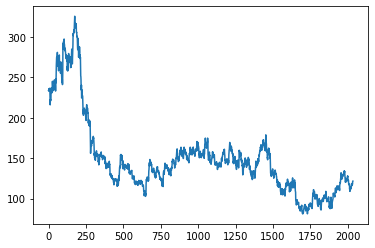

In [9]:
plt.plot(df1)

### Observation :- It is non stationary

### Test for stationary

* Since we are using LSTM model no need of stationary data.
* If timeseries is done by arima model then need to make the data stationary, as here p value is less than 0.05 so reject the null hypothesis

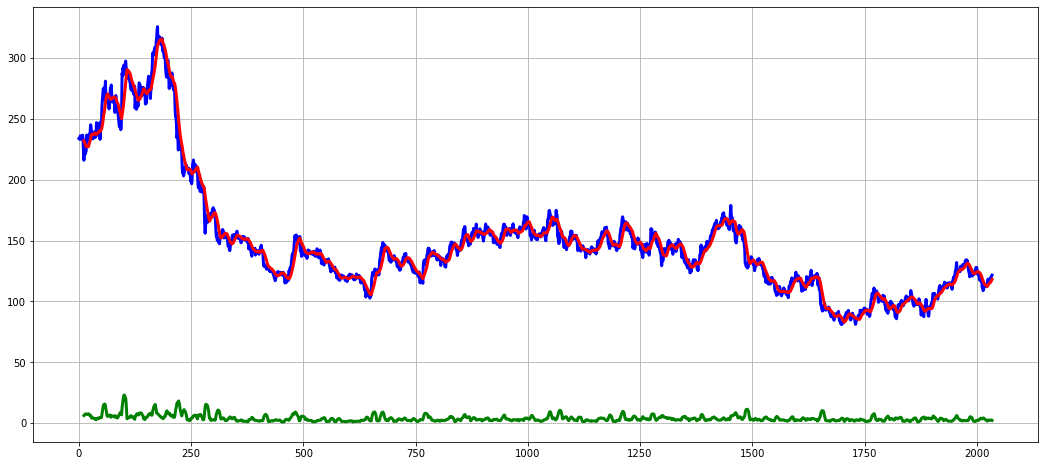

Test Statistics             -1.738101
p-value                      0.411596
No of lags                  16.000000
No of observation used    2018.000000
critical value (1%)         -3.433595
critical value (5%)         -2.862973
critical value (10%)        -2.567533
dtype: float64


In [10]:
def stationary_test(time_series):
    try:
        rolling_mean = time_series.rolling(12).mean()
        rolling_std = time_series.rolling(12).std()

        plt.figure(figsize=(18,8))
        plt.grid('both')
        plt.plot(time_series, color='blue', label='Orginal', linewidth=3)
        plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=3)
        plt.plot(rolling_std, color='green', label='Rolling Std', linewidth=3)
        plt.show()
        
        adft = adfuller(time_series, autolag='AIC')
        output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No of lags', 'No of observation used'])
        
        for key, values in adft[4].items():
            output['critical value (%s)'%key]=values
        
        print(output)
    
    except Exception as e:
        print(e)
stationary_test(df1) 

In [11]:
#Lets scale the data by using Min Max scaler with the range of 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))

# Since it contains the single feature,reshape it to have a 2 dim
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1)) 

In [12]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [13]:
#Converting the data from 1d to 2d
df1.ndim

2

In [14]:
df1.shape

(2035, 1)

#### Since it is a time series problem we are making training and testing data by splitting in the 70:30 ratio

In [15]:
training_size = int(len(df) * 0.70)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size], df[training_size:len(df)]

In [16]:
train_data = df[0:training_size]

In [17]:
train_data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
1419,2013-01-03,167.30,168.90,165.20,165.60,165.85,4841015,8085.96
1420,2013-01-02,161.50,167.30,161.30,167.05,166.65,7201391,11884.96
1421,2013-01-01,160.55,162.50,160.30,161.00,160.80,3237577,5226.72
1422,2012-12-31,160.50,161.75,159.55,159.90,159.95,1579057,2531.61


In [18]:
training_size, test_size

(1424, 611)

In [19]:
#Over here we have created the x train dataset but its stored in list 
x=[]
dataset = df1
for i in range(len(dataset) - 100 - 1):
    a = dataset[i:(i + 100), 0]
    x.append(a)

In [20]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i + time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
time_step = 100
X_train, y_train = create_dataset(df1, time_step)
X_test, y_test = create_dataset(df1, time_step)

In [22]:
X_train.shape[0], X_test.shape[1], 1

(1934, 100, 1)

In [23]:
# converting the array into 3d 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
#Stacked LSTM with 3 sequential data and then dense
model=Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
#return_sequences=it will output all the hidden states of each time steps.
model.add(LSTM(50, return_sequences=True))
#50 is nothing but neurons we are passing
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')#This adam optimize the value faster than other optimizer algorithm,its like gradient descent

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
31/31 [==============================] - 11s 179ms/step - loss: 0.0144 - val_loss: 0.0016
Epoch 2/100
31/31 [==============================] - 4s 142ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
31/31 [==============================] - 4s 142ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
31/31 [==============================] - 4s 143ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
31/31 [==============================] - 4s 143ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
31/31 [==============================] - 5s 147ms/step - loss: 0.0010 - val_loss: 9.1503e-04
Epoch 7/100
31/31 [==============================] - 5s 147ms/step - loss: 9.3348e-04 - val_loss: 8.8275e-04
Epoch 8/100
31/31 [==============================] - 5s 150ms/step - loss: 8.8848e-04 - val_loss: 9.2673e-04
Epoch 9/100
31/31 [==============================] - 4s 145ms/step - loss: 9.4634e-04 - val_loss: 8.2429e-04
Epoch 10/100
31/31 [==============================] - 5s 149ms

Epoch 76/100
31/31 [==============================] - 5s 157ms/step - loss: 2.1538e-04 - val_loss: 1.8506e-04
Epoch 77/100
31/31 [==============================] - 5s 162ms/step - loss: 2.0231e-04 - val_loss: 3.1037e-04
Epoch 78/100
31/31 [==============================] - 5s 159ms/step - loss: 2.3342e-04 - val_loss: 1.7926e-04
Epoch 79/100
31/31 [==============================] - 5s 162ms/step - loss: 2.0263e-04 - val_loss: 2.1710e-04
Epoch 80/100
31/31 [==============================] - 5s 155ms/step - loss: 2.0282e-04 - val_loss: 2.0488e-04
Epoch 81/100
31/31 [==============================] - 5s 155ms/step - loss: 2.2054e-04 - val_loss: 1.7490e-04
Epoch 82/100
31/31 [==============================] - 5s 155ms/step - loss: 1.8370e-04 - val_loss: 2.6310e-04
Epoch 83/100
31/31 [==============================] - 5s 155ms/step - loss: 2.0035e-04 - val_loss: 1.9203e-04
Epoch 84/100
31/31 [==============================] - 5s 154ms/step - loss: 1.8198e-04 - val_loss: 1.8407e-04
Epoch 85/1

In [27]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

61/61 [==============================] - 2s 25ms/step


In [28]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
math.sqrt(mean_squared_error(y_train, train_predict))

150.12781086067312

In [30]:
math.sqrt(mean_squared_error(y_test, test_predict))

150.12781086067312

In [40]:
len(train_predict) + (look_back*2) + 1

2135

In [49]:
test_predict.shape[0]

1934

In [52]:
train_predict.shape

(1934, 1)

In [51]:
trainPredictPlot[look_back:len(train_predict) + look_back, :].shape

(1934, 1)

In [54]:
test_predict.shape

(1934, 1)

In [86]:
testPredictPlot[look_back:len(train_predict) + look_back, :].shape

(1934, 1)

In [33]:
scaler.inverse_transform(df1)

array([[233.75],
       [233.25],
       [234.25],
       ...,
       [120.65],
       [120.9 ],
       [121.55]])

In [41]:
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

In [63]:
len(train_predict) + (look_back*2) + 1

2135

In [85]:
len(df)-1

2034

In [66]:
testPredictPlot[:, :] = np.nan

In [91]:
testPredictPlot[len(train_predict) + (look_back * 2) + 1: len(df) - 1, :]

array([], shape=(0, 1), dtype=float64)

In [65]:
len(df) - 1 

2034

In [96]:
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1: len(df) - 1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (1934,1) into shape (0,1)

In [71]:
test_data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1424,2012-12-27,160.40,162.50,159.00,159.55,159.65,5550194,8896.81
1425,2012-12-26,161.75,162.50,159.75,160.70,160.15,1645334,2651.56
1426,2012-12-24,161.70,162.60,160.00,160.20,160.65,1922825,3100.35
1427,2012-12-21,163.00,165.45,160.25,160.75,160.85,2415570,3934.04
1428,2012-12-20,165.00,165.35,162.30,163.15,162.95,1960923,3202.39
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


In [78]:
x_input = np.array(test_data[511:]).reshape(1,-1)
x_input.shape

(1, 800)

In [79]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [92]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [115.9 110.2 111.4 111.5 1285356 1454.58 Timestamp('2010-12-08 00:00:00')
 115.0 115.4 113.7 114.8 114.85 1032008 1181.91
 Timestamp('2010-12-07 00:00:00') 115.6 115.75 113.6 115.7 115.25 566010
 649.53 Timestamp('2010-12-06 00:00:00') 113.2 115.65 113.2 114.75 114.95
 1036023 1191.18 Timestamp('2010-12-03 00:00:00') 116.0 116.0 112.6 113.5
 114.1 606153 692.32 Timestamp('2010-12-02 00:00:00') 115.9 117.5 114.35
 115.55 115.25 887683 1026.67 Timestamp('2010-12-01 00:00:00') 113.5 116.0
 113.0 114.5 114.75 628391 722.87 Timestamp('2010-11-30 00:00:00') 112.95
 113.9 111.05 113.0 112.95 993783 1120.16 Timestamp('2010-11-29 00:00:00')
 113.4 114.0 110.1 113.1 112.95 725219 814.61
 Timestamp('2010-11-26 00:00:00') 112.4 113.5 103.5 113.0 112.45 2279992
 2520.35 Timestamp('2010-11-25 00:00:00') 118.5 118.5 107.25 111.5 109.95
 2586020 2873.33 Timestamp('2010-11-24 00:00:00') 118.1 118.9 116.15 117.0
 116.8 516440 609.14 Timestamp('2010-11-23 00:00:00') 116.1 119.7 114.1
 117.25 

ValueError: cannot reshape array of size 798 into shape (1,100)